# SLAITAI Workshop Demo

This notebook runs the experiments:

1. **Calculation of Shannon's Entropy**

2. **Limitations of Estimate Entropy and Symbol Probabilities Using Histogram**

3. **Fast Entropy Estimator**

4. **Symbolization by Word Length**

5. **Authorship Detection**

6. **Symbolization by Signal Amplitude**
   
7. **Symbolization of EEG Signals**

8. **Information Topology for EEG**


## Setup Colab Environment -- skip this if you run the notebook locally

In [1]:
# Run the code first, this will mount your google drive and append system path
# this will ensure the import of our libraries.
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/SLAITAI workshop')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# set the working dir for reading data
working_dir = '/content/drive/MyDrive/Colab Notebooks/SLAITAI workshop/'

## Load Python Libraries

In [3]:

# required common libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import codecs
import pandas as pd
# required SLAITAI libraries
import symbolize_fn as symfn
from build_entropy_model import *
import ZML_cZML_entropy as slaitai_entropy
import check_authorship_detection as author_detect
from plot_settings import *
import eeg_deap_plots9 as eegfn
import video_sym as videosym

## Experiment 1: Calculation of Shannon's Entropy

In [4]:
def ShannonEntropy(p):
    # p : array of probabilities
    M = len(p)
    He = 0
    # Iterate over probabilities
    for r in range(M):
        He = He + (p[r] * np.log2(p[r]))
    He = -He
    return He

pA = [0.5,0.25,0.125,0.125]
entropy = ShannonEntropy(pA)
print(entropy)

1.75


## Experiment 2: Limitations of Estimate Entropy and Symbol Probabilities Using Histogram

**Aim: how good or bad is a conventional maximum likelihood estimator for estimating probabilities. Can't be too bad surely?**

In [5]:
# set a random seed of 2
np.random.seed(2)

# define symbols to be use
symbols = ['A', 'B', 'C', 'D']
# set probabilities for each symbols
probs = [0.5, 0.25, 0.125, 0.125]

# generate 1000 random examples based on the pre-defined probability
gen_symbols = np.random.choice(symbols, 1000, p=probs)

# have a check up on the first 30 generated symbols
print(gen_symbols[:30])

['A' 'A' 'B' 'A' 'A' 'A' 'A' 'B' 'A' 'A' 'B' 'B' 'A' 'B' 'A' 'C' 'C' 'A'
 'C' 'A' 'B' 'A' 'A' 'A' 'A' 'B' 'A' 'A' 'A' 'A']


**How good is a histogram estimator?**


In [6]:


# use gen_symbol_probability to calculate the probability distribution
# the function returns a dictionary
est_prob = symfn.gen_symbol_probability(gen_symbols)
print('The probability distribution for the randomly generated 1000 examples is ', est_prob)
print('The true probabilities are ', probs)
# esimate Shannon entropy for
He = ShannonEntropy(list(est_prob.values()))
print('The entropy for the randomly generated 1000 examples is ', He)

# but the 'tru' probability should be
true_prob = ShannonEntropy(probs)
print('The true entropy is ', true_prob)

The probability distribution for the randomly generated 1000 examples is  {'A': 0.534, 'B': 0.242, 'C': 0.095, 'D': 0.129}
The true probabilities are  [0.5, 0.25, 0.125, 0.125]
The entropy for the randomly generated 1000 examples is  1.6824231549794413
The true entropy is  1.75


**How good is a histogram estimator with only 10 samples?**

We usually won't have the luxury to access the full population. Imagine we only have a ultra small sample set, then what's the Shannon entropy for the sample set?

In [7]:
# get the first 10 values from the 1000 samples.
Nx = 20
sample_10 = gen_symbols[:Nx]
# get the probability distribution of the first 10 samples
est_prob_10 = symfn.gen_symbol_probability(sample_10)
print('The probability distribution for the first {:d} samples is'.format(Nx), est_prob_10)

# calculate Shannon entropy for the first 10 samples

He = ShannonEntropy(list(est_prob_10.values()))
print('The entropy for the first {:d} samples is {:4.3f}'.format(Nx, He))
print('The error from the true entropy is', entropy-He)

The probability distribution for the first 20 samples is {'A': 0.6, 'B': 0.25, 'C': 0.15}
The entropy for the first 20 samples is 1.353
The error from the true entropy is 0.3972758043753455


## Experiment 3: Fast Entropy Estimator

**Step 1: Build Fast Entropy Model to obtain the paramaters**

In [8]:
M = 4  # Alphabet size
Nq = 50000 # number of examples
Nw = 5000 # Window length to obtain entropy
Ns = 50 # Number of random trials to get statistical average
Kstart = 8
Kend = 60
Kstep = 1
Rmax = 5
R = 1       # Estimate model parameters for rank R = 1

# Running this code can be slow, alternatively, use the pre-calculated values.
# ap, bp, cp = BuildEntropyModel(Nq, Nw, Ns, Kstart, Kstep, Kend, Rmax, M, R, DoPlot=0, DoFileSave=0, DoVerbose=0)

ap = 0.0075
bp = 4.2026
cp = 4.5362

**Step 2: Apply Fast Entropy Model**

In [9]:
# Estimate entropy using fast entropy model

# the sequence/list/array of the symbols
# typically it only needs a small number (e.g. <50) of symbols
symbols = sample_10
# the length of samples
symbol_len = len(symbols)
# corresponds to the estimate model parameters for rank R
# if in build entropy model stage, R is set to 1,
# then selected_symbol = the most frequent symbol
# if R=2, then selected_symbol = the 2nd most frequent symbol
# by default R=1, use most_frequent_symbol to get the most frequent symbol
selected_symbol = symfn.most_frequent_symbol(symbols)

He, p = slaitai_entropy.FastEntropy4_czml(symbols, symbol_len, selected_symbol, M, ap, bp, cp, zml_model='zml', eta=0.2)
print('The entropy estimated  from the first 10 samples using Fast Entropy is ', He)
print('The probability estimated  from the first 10 samples using Fast Entropy is ',p)

The entropy estimated  from the first 10 samples using Fast Entropy is  1.8777807413450622
The probability estimated  from the first 10 samples using Fast Entropy is  [0.41805369 0.25702712 0.18337248 0.1415467 ]


## Experiment 4: Symbolization by Word Length

In [10]:
# sample text
text = 'Emotion is a psycho-physiological process triggered by conscious and/or \
unconscious perception of an object or situation and is often associated with mood'

# For real-runs, NLTK word_tokenize is recommanded.
# NLTK word_tokenize will break up a piece of text into a list of words
# More sophisticated text pre-processing technique may be applied as required
# e.g in the text and/or will be treated as one word
word_list = text.split(' ')
print(word_list)
# Set up the experiment to run where condition <= element
conditions = [3,7]

# letters – list of each symbol for a condition
# always one more element than condition list for ‘everything else’
letters = ['A', 'B', 'C']

# in this setting, symbols are generated based on
# if len(word) > 0 and <= 3: A
# elif len(word) > 3 and <= 7: B
# anything else : C
symbols, _, _ = symfn.symbolize_by_wordlengths(word_list, conditions, letters)
# Output is a sequence of symbols corresponding in this case to text wordlength
print(symbols)


['Emotion', 'is', 'a', 'psycho-physiological', 'process', 'triggered', 'by', 'conscious', 'and/or', 'unconscious', 'perception', 'of', 'an', 'object', 'or', 'situation', 'and', 'is', 'often', 'associated', 'with', 'mood']
['B', 'A', 'A', 'C', 'B', 'C', 'A', 'C', 'B', 'C', 'C', 'A', 'A', 'B', 'A', 'C', 'A', 'A', 'B', 'C', 'B', 'B']


## Experiment 5: Authorship Detection

This experiment shows using the symbolization by word length and Fast Entropy algorithm to detect different authors for two books.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!




 Compute Entropy on the SYMBOLIC text 

0
Ha(0) = 4.2714 He(0) = 2.3357
1
Ha(1) = 4.2768 He(1) = 2.3456
2
Ha(2) = 4.2705 He(2) = 2.2638
3
Ha(3) = 4.2717 He(3) = 2.3114
4
Ha(4) = 4.2641 He(4) = 2.3349
5
Ha(5) = 4.2707 He(5) = 2.2996
6
Ha(6) = 4.2756 He(6) = 2.3426
7
Ha(7) = 4.2587 He(7) = 2.3094
8
Ha(8) = 4.2709 He(8) = 2.3069
9
Ha(9) = 4.2748 He(9) = 2.3419
10
Ha(10) = 4.2738 He(10) = 2.3648
11
Ha(11) = 4.2697 He(11) = 2.4528
12
Ha(12) = 4.2681 He(12) = 2.3184
13
Ha(13) = 4.2699 He(13) = 2.3456
14
Ha(14) = 4.2732 He(14) = 2.3466
15
Ha(15) = 4.2600 He(15) = 2.2766
16
Ha(16) = 4.2717 He(16) = 2.3073
17
Ha(17) = 4.2755 He(17) = 2.3126
18
Ha(18) = 4.2721 He(18) = 2.2639
19
Ha(19) = 4.2672 He(19) = 2.2999
20
Ha(20) = 4.2658 He(20) = 2.3088
21
Ha(21) = 4.2645 He(21) = 2.2812
22
Ha(22) = 4.2701 He(22) = 2.3363
23
Ha(23) = 4.2720 He(23) = 2.3341
24
Ha(24) = 4.2736 He(24) = 2.2737
25
Ha(25) = 4.2695 He(25) = 2.2879
26
Ha(26) = 4.2743 He(26) = 2.2852
27
Ha(27) = 4.2694 He(27) = 2.3027
28
Ha(28

/content/drive/MyDrive/Colab Notebooks/SLAITAI workshop/check_authorship_detection.py:527: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect1 = patches.Rectangle(( 119, 4.247), 5, 0.0017, **rect_params)
/content/drive/MyDrive/Colab Notebooks/SLAITAI workshop/check_authorship_detection.py:528: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect2 = patches.Rectangle((243, 4.23), 5, 0.0017, **rect_params)
/content/drive/MyDrive/Colab Notebooks/SLAITAI workshop/check_authorship_detection.py:529: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect3 = patches.Rectangle((364, 4.198), 5, 0.0017, **rect_params)


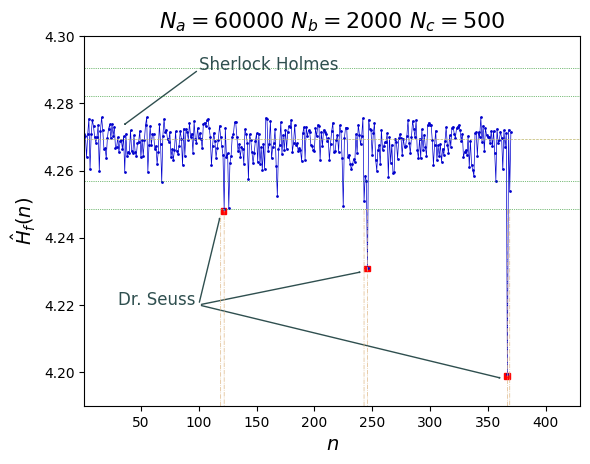

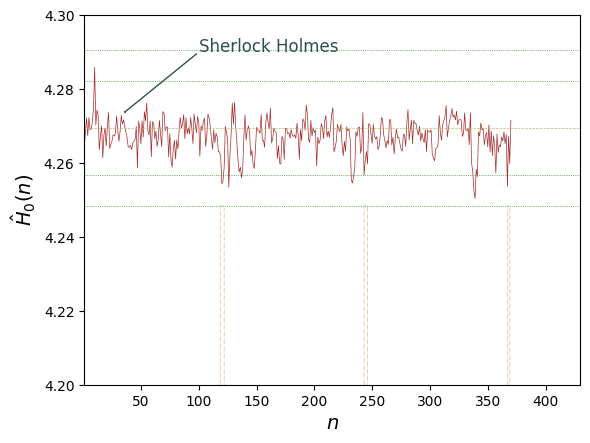


Done



In [11]:
import nltk
nltk.download('punkt')
# symbolization code
# conditions = [2, 3, 5, 8]
# letters = ['A', 'B', 'C', 'D', 'E']
author1_file = working_dir + 'sherlockholmes2.txt'
author2_file = working_dir + 'drseusscat.txt'
author_detect.check_authorship_detection(author1_file, author2_file, zml_model='zml')

## Experiment 6: Symbolization by Signal Amplitude

**first: generate a sample sine wave dataset**

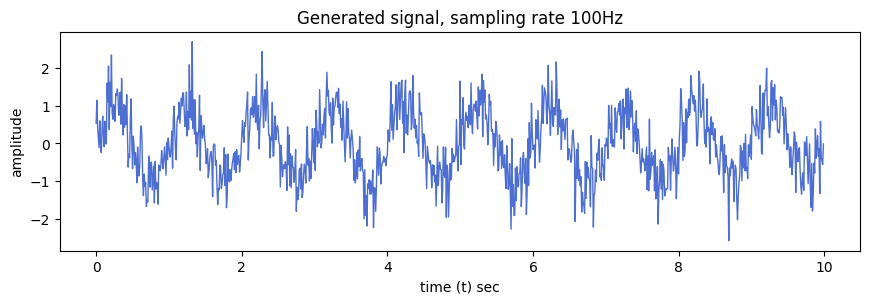

In [12]:
# sine wave settings
duration = 10  # seconds
sampling_rate = 100  # Hz
frequency1 = 1  # Hz
frequency2 = 7  # Hz

# Generate time values for plotting
t = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)
Nt = len(t)
mu, sigma = 0, 0.1
# add noise
noise = 5*np.random.normal(mu, sigma, [Nt])
# Generate sine wave
amplitude = np.sin(2 * np.pi * frequency1 * t) + 0.2*np.sin(2 * np.pi * frequency2 * t) + noise

# Plot the sine wave
fig = plt.figure(figsize=(10, 3))
ax = fig.add_axes([0.15, 0.17, 0.8, 0.73])
ax.plot(t, amplitude,
             marker='o',  # each marker will be rendered as a circle
             markersize=0,  # marker size
             markerfacecolor='red',  # marker facecolor
             markeredgecolor='black',  # marker edgecolor
             markeredgewidth=0.2,  # marker edge width
             linestyle='solid',  # line style will be dash line
             linewidth=PlotLineWidth,  # line width
             alpha=0.9,
             color=royalblue3)

ax.set_xlabel("time (t) sec")
ylabelstr = "amplitude"
ax.set_ylabel(ylabelstr)

ax.set_title("Generated signal, sampling rate 100Hz")
plt.show()



**Second: symbolizing the sine wave signals**

In [13]:
sine_symbols = []
for amp in amplitude:
    if(amp >= 0.1) :
        sine_symbols.append('A')
    elif (amp >= 0) and (amp < 1):
        sine_symbols.append('B')
    elif(amp >= -1) and (amp < 0):
        sine_symbols.append('C')
    elif (amp < -1):
        sine_symbols.append('D')
print(sine_symbols[:30])

['A', 'A', 'A', 'A', 'C', 'A', 'B', 'C', 'A', 'A', 'A', 'C', 'A', 'C', 'C', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A']


In [14]:
def calculate_entropy_using_fe(sine_symbols, block_size):

    block_entropy = []
    # cut the sequence into blocks based on the defined block size
    # then calculate the entropy for the block
    for i in range(0, len(sine_symbols), block_size):

        current_chunk = sine_symbols[i:i+block_size]
        # print(current_chunk)

        # calculate the entropy
        selected_symbol = symfn.most_frequent_symbol(current_chunk)
        Naw = len(current_chunk)
        M=4

        entropy, p = slaitai_entropy.FastEntropy4_czml(current_chunk, Naw, selected_symbol,
                                                       M, 0.0075, 4.2026, 4.5362, zml_model='zml', eta=0.2)
        block_entropy.append(entropy)
        # print(np.round(entropy, 4), np.round(p, 4))

    # plot
    timeline = np.arange(0, 10, block_size/100)

    fig = plt.figure(figsize=(10, 3))
    ax = fig.add_axes([0.15, 0.17, 0.8, 0.73])
    ax.plot(timeline, block_entropy,
                 marker='o',  # each marker will be rendered as a circle
                 markersize=3,  # marker size
                 markerfacecolor='red',  # marker facecolor
                 markeredgecolor='black',  # marker edgecolor
                 markeredgewidth=0.2,  # marker edge width
                 linestyle='solid',  # line style will be dash line
                 linewidth=PlotLineWidth,  # line width
                 alpha=0.9,
                 color=royalblue3)

    ax.set_xlabel("time (t) sec")
    ylabelstr = "H(x)"
    ax.set_ylabel(ylabelstr)
    ax.set_title("Fast Entropy for block size of " + str(block_size))
    plt.show()

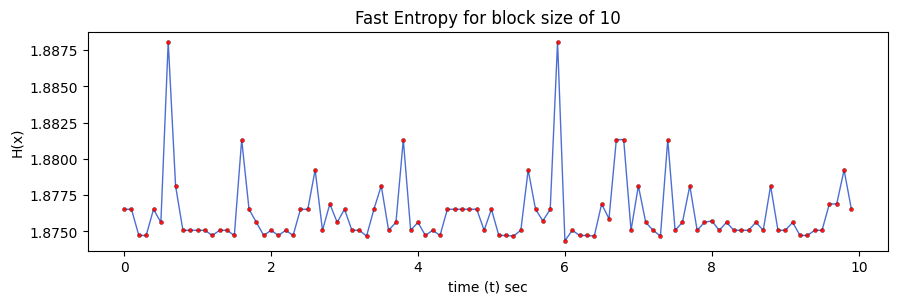

In [15]:
calculate_entropy_using_fe(sine_symbols, 10)

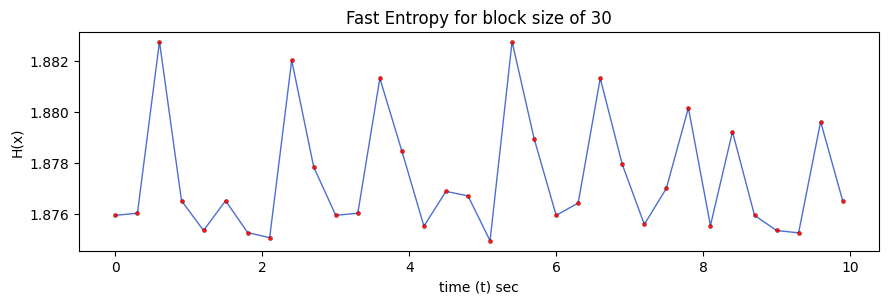

In [16]:
calculate_entropy_using_fe(sine_symbols, 30)

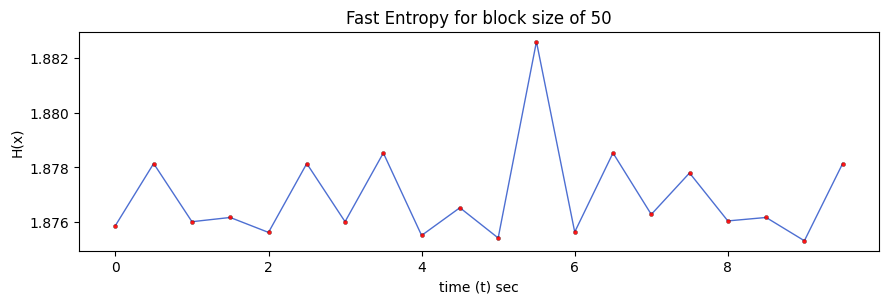

In [17]:
calculate_entropy_using_fe(sine_symbols, 50)

## Experiment 7: Symbolization of EEG Signals




In [18]:
# read a .mat format eeg data
mat_data = scipy.io.loadmat(working_dir+'s01.mat')

# the loaded data shape is

#data   40 x 40 x 8064(128*63)  video/trial x channel x data
#labels 40 x 4  video/trial x label (valence, arousal, dominance, liking)

data = mat_data['data']
print(data.shape)

labels = mat_data['labels']
print(labels.shape)

(40, 40, 8064)
(40, 4)


In [19]:
# max trial number is 40
# max channel number is 40 however only the first 32 channels are EEG signals
# the default sampling rate for this cleaned dataset is 128

trial_no = 1
channel_no = 2
sample_rate = 128
channel_data = data[trial_no][channel_no ]

# exatact a wave with certain bandpass
# bandpass: delta, theta, alpha, beta, gamma
gamma_wave_data = eegfn.butter_bandpass_filter_eeg(channel_data,'gamma', sample_rate, order=6)


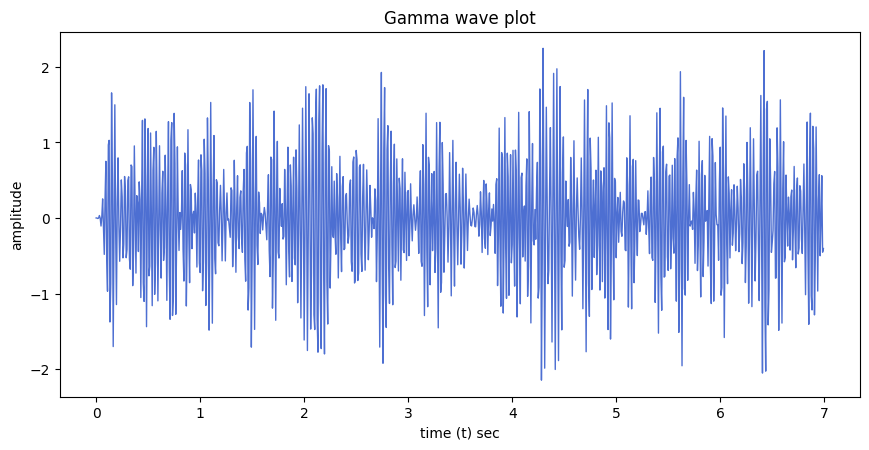

In [20]:
# plot EEG wave
eegfn.plot_eeg(gamma_wave_data, showing_sec=7, down_samp_factor=1, titlestr='Gamma wave plot', figsize=(10, 5))

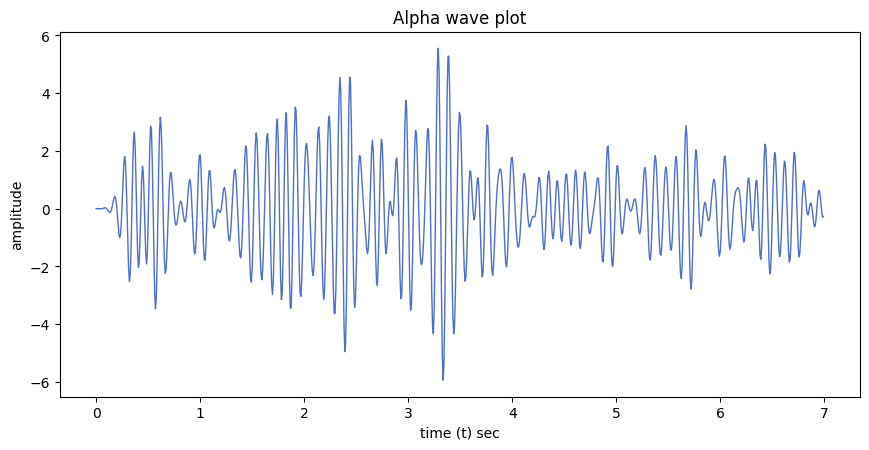

In [21]:
# change to another trial and channel
channel_data = data[2][23 ]

# exatact a wave with certain bandpass
# bandpass: delta, theta, alpha, beta, gamma
alpha_wave_data = eegfn.butter_bandpass_filter_eeg(channel_data,'alpha', sample_rate, order=6)
# plot EEG wave
eegfn.plot_eeg(alpha_wave_data, showing_sec=7, down_samp_factor=1, titlestr='Alpha wave plot', figsize=(10, 5))

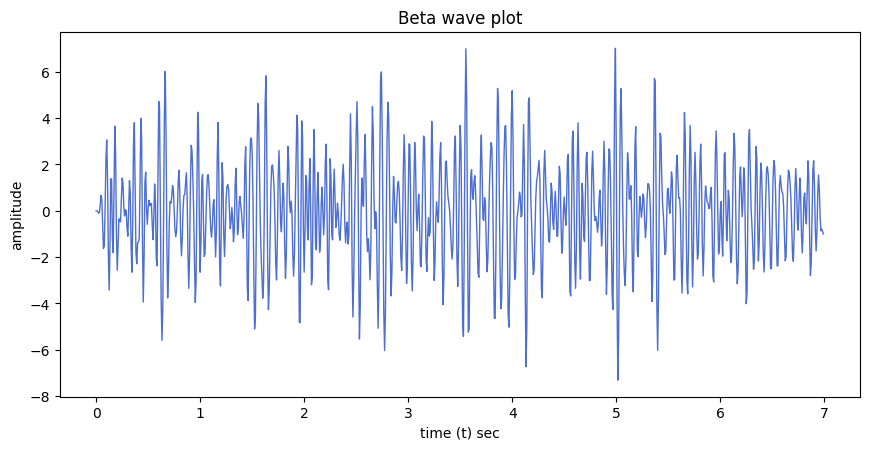

In [22]:
# change to another trial and channel
channel_data = data[3][10]

# exatact a wave with certain bandpass
# bandpass: delta, theta, alpha, beta, gamma
beta_wave_data = eegfn.butter_bandpass_filter_eeg(channel_data,'beta', sample_rate, order=6)
# plot EEG wave
eegfn.plot_eeg(beta_wave_data, showing_sec=7, down_samp_factor=1, titlestr='Beta wave plot', figsize=(10, 5))

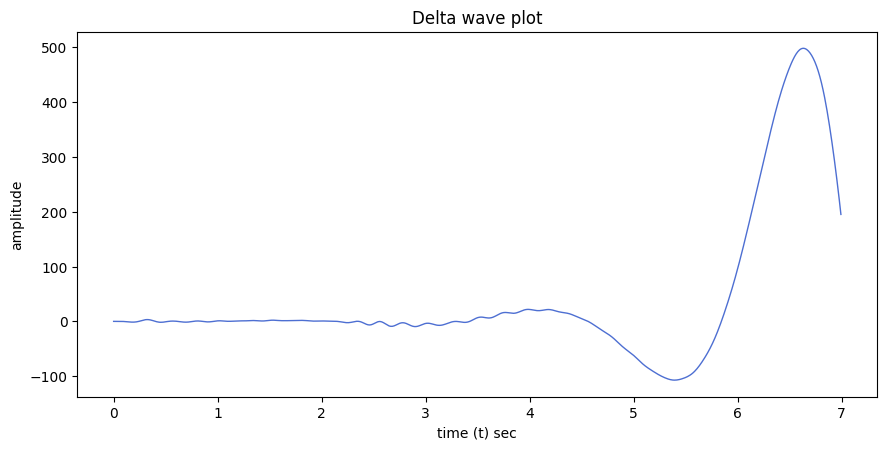

In [23]:
# change to another trial and channel
channel_data = data[3][10]

# exatact a wave with certain bandpass
# bandpass: delta, theta, alpha, beta, gamma
delta_wave_data = eegfn.butter_bandpass_filter_eeg(channel_data,'delta', sample_rate, order=6)
# plot EEG wave
eegfn.plot_eeg(delta_wave_data, showing_sec=7, down_samp_factor=1, titlestr='Delta wave plot',figsize=(10, 5))

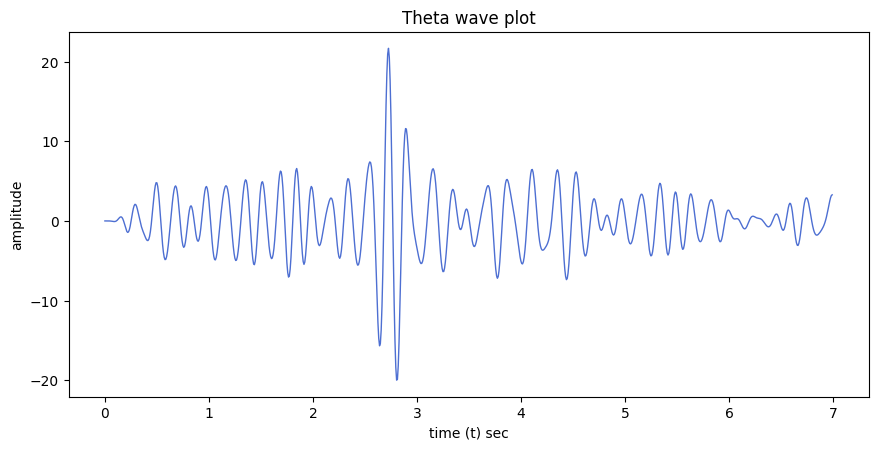

In [24]:
# change to another trial and channel
channel_data = data[3][10]

# exatact a wave with certain bandpass
# bandpass: delta, theta, alpha, beta, gamma
theta_wave_data = eegfn.butter_bandpass_filter_eeg(channel_data,'theta', sample_rate, order=6)
# plot EEG wave
eegfn.plot_eeg(theta_wave_data, showing_sec=7, down_samp_factor=1, titlestr='Theta wave plot',figsize=(10, 5))

**Save .mat EEG data in .csv format**

The following code shows how to save EEG data from a trial/experiment.

DEAP data is 40 x 40 x 8064(128*63) video/trial x channel x data

The code saves channel_index 1 (channgel number 2 as Python array starts with index 0) for the first 2 trials' signals from participant s01 into 2 csv files trial_1_channel_2_data.csv and trial_2_channel_2_data.csv.

The saved data has a dimension of [8063,]

In [25]:
# read a .mat format eeg data
mat_data = scipy.io.loadmat(working_dir+'s01.mat')

# Extract data
data = mat_data['data']

# Get the dimensions of the data
num_trials, num_channels, num_data_points = data.shape

# Iterate through one or all trials
# The following example is to save only 2 trials with channels  2
channel_index_to_save = 1

# Iterate through each trial
for trial_index in range(2):
    # Extract the data for the specified channel
    channel_data = data[trial_index, channel_index_to_save, :]

    # Create a DataFrame for the current video/trial and channel
    _data = pd.DataFrame({'Amplitude': channel_data})

    # Save the DataFrame to a CSV file (adjust the file name as needed)
    csv_file_name = working_dir+f'trial_{trial_index + 1}_channel_{channel_index_to_save + 1}_data.csv'
    np.savetxt(csv_file_name, channel_data, delimiter=',', comments='')

    print(f'Saved {csv_file_name}')



Saved /content/drive/MyDrive/Colab Notebooks/SLAITAI workshop/trial_1_channel_2_data.csv
Saved /content/drive/MyDrive/Colab Notebooks/SLAITAI workshop/trial_2_channel_2_data.csv


Load a .csv EEG data that contains EEG signal collected from one channel

(8063,)
[ 1.39008270e+00  1.83509881e+00 -1.11073832e+00 -2.59062203e+00
 -1.84425787e+00 -7.39794269e-01  2.39573835e+00  3.97638944e+00
  2.03843046e-03 -6.18212456e+00 -1.00808302e+01 -8.84823407e+00
 -4.26872670e+00 -2.18812278e-01  5.47654070e+00  1.14994103e+01
  1.11885411e+01  6.79755797e+00  2.05235775e+00 -4.16367511e+00
 -7.57429744e+00 -5.53163528e+00 -2.43023724e+00 -3.78047343e-01
 -5.79384006e-01 -2.33607458e+00 -8.06960332e-01  2.36697814e+00
  2.71206377e+00  2.27860794e+00]


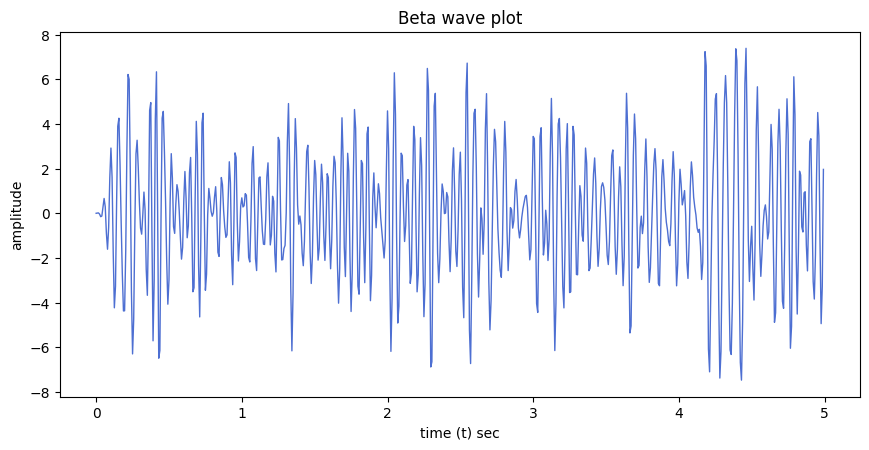

In [26]:
# Read the CSV file for the specified trial index
csv_file_name =  working_dir + f'trial_1_channel_2_data.csv'
channel_data = np.loadtxt(csv_file_name, delimiter=',', skiprows=1)
print(channel_data.shape)
print(channel_data[:30])
alpha_wave_data = eegfn.butter_bandpass_filter_eeg(channel_data,'beta', 128, order=6)
eegfn.plot_eeg(alpha_wave_data, showing_sec=5, down_samp_factor=1, titlestr='Beta wave plot', figsize=(10, 5))


**Symbolization of EEG Signals**


In [27]:
# using bigger down_sample_factor just for showcase
down_sample_factor = 32
trial_no = 1
channel_no = 2

sample_signal = data[trial_no][channel_no][::down_sample_factor]
gamma_wave_data = eegfn.butter_bandpass_filter_eeg(sample_signal,'gamma', sample_rate, order=6)

norm_gamma_data = eegfn.min_max_norm(gamma_wave_data, print_detail=1)
unigram_symbols = eegfn.symbolise_amplitude_states(norm_gamma_data, ngram=1)
print(unigram_symbols[:30])
print('unique symbols are: ', np.unique(unigram_symbols))

normalized data mean:  0.5033641345919417
normalized data std:  0.1793428827953027
['2', '2', '1', '2', '2', '1', '1', '2', '2', '1', '2', '2', '1', '1', '2', '1', '1', '3', '1', '0', '3', '3', '0', '1', '3', '0', '0', '3', '3', '0']
unique symbols are:  ['0' '1' '2' '3']


In [28]:
trigram_symbols = eegfn.symbolise_amplitude_states(norm_gamma_data, ngram=3)
print(trigram_symbols[:30])
print('unique symbols are: ', np.unique(trigram_symbols))

['221', '212', '122', '221', '211', '112', '122', '221', '212', '122', '221', '211', '112', '121', '211', '113', '131', '310', '103', '033', '330', '301', '013', '130', '300', '003', '033', '330', '300', '003']
unique symbols are:  ['003' '013' '021' '022' '023' '031' '032' '033' '101' '102' '103' '111'
 '112' '113' '120' '121' '122' '130' '131' '132' '201' '202' '210' '211'
 '212' '220' '221' '230' '231' '232' '300' '301' '302' '303' '310' '311'
 '312' '320' '321' '330']


## Experiment 8: Information Topology for EEG

loaded raw data shape: /content/drive/MyDrive/Colab Notebooks/SLAITAI workshop/s01.mat (40, 40, 8064)
loaded raw data shape: /content/drive/MyDrive/Colab Notebooks/SLAITAI workshop/s02.mat (40, 40, 8064)
loaded raw data shape: /content/drive/MyDrive/Colab Notebooks/SLAITAI workshop/s03.mat (40, 40, 8064)
loaded raw data shape: /content/drive/MyDrive/Colab Notebooks/SLAITAI workshop/s04.mat (40, 40, 8064)
loaded raw data shape: /content/drive/MyDrive/Colab Notebooks/SLAITAI workshop/s05.mat (40, 40, 8064)


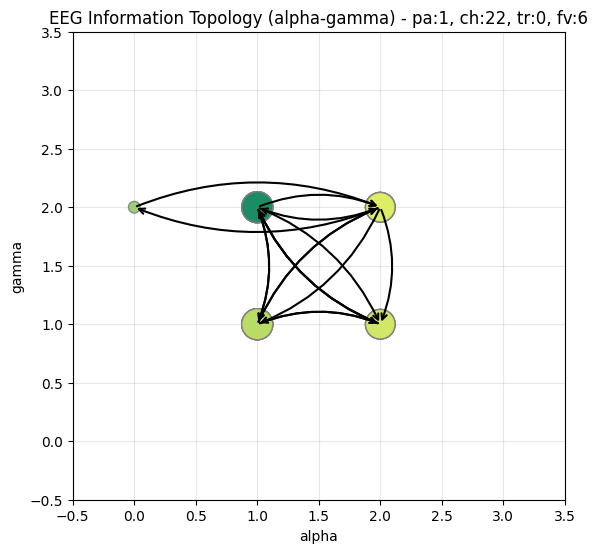

[1.30257265 1.95292973 2.4077217  2.75776476]
1.893977528953703
[0.40540263 0.25829118 0.18845321 0.14785298]
['0', '3', '2', '1']


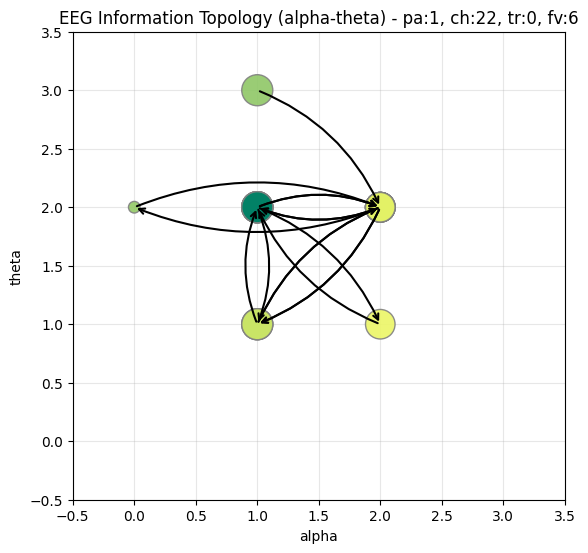

[1.30402064 1.95271538 2.40647088 2.75576734]
1.8944806205243305
[0.40499594 0.25832956 0.18861667 0.14805783]
['3', '0', '1', '2']


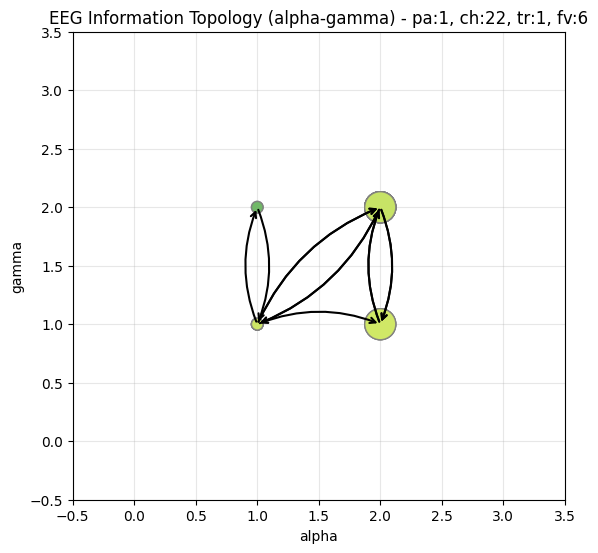

[1.30344588 1.95280035 2.4069671  2.75655975]
1.8942811201225833
[0.40515732 0.25831434 0.18855181 0.14797653]
['3', '0', '1', '2']


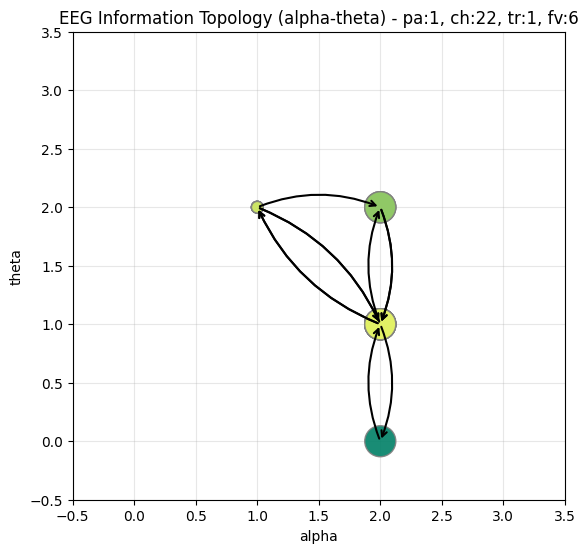

[1.31904496 1.95054342 2.39362565 2.73525923]
1.8996055203384483
[0.40080017 0.25871876 0.19030355 0.15017752]
['3', '0', '1', '2']


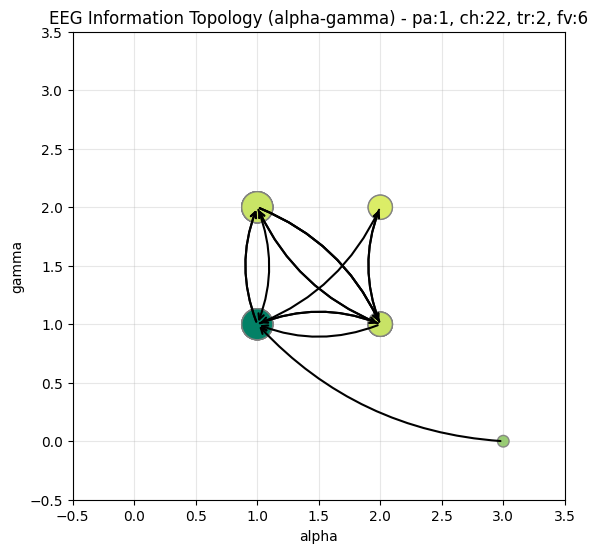

[1.30660911 1.95233452 2.40424051 2.75220575]
1.895375940539583
[0.40426995 0.25839776 0.1889085  0.14842379]
['0', '3', '2', '1']


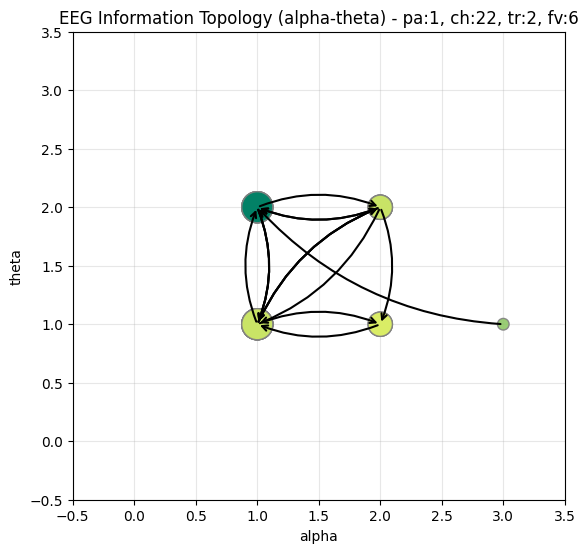

[1.31830053 1.95064896 2.39425643 2.7362659 ]
1.899355669017095
[0.40100704 0.25869983 0.19022036 0.15007277]
['3', '0', '1', '2']


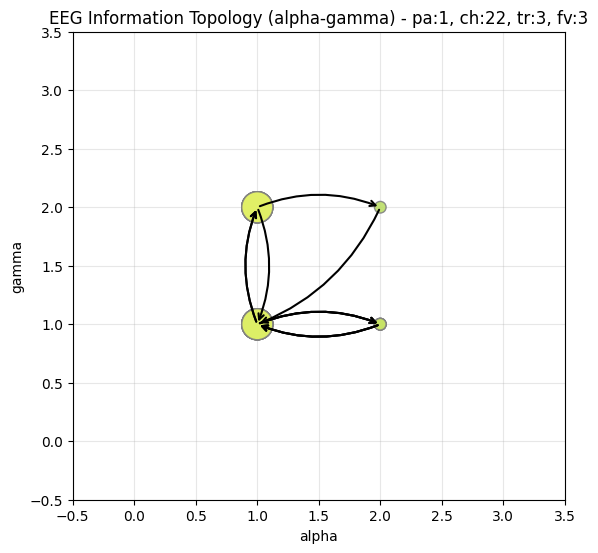

[1.30118336 1.95313628 2.40892398 2.75968463]
1.8934933053479508
[0.40579321 0.2582542  0.18829623 0.14765636]
['0', '3', '2', '1']


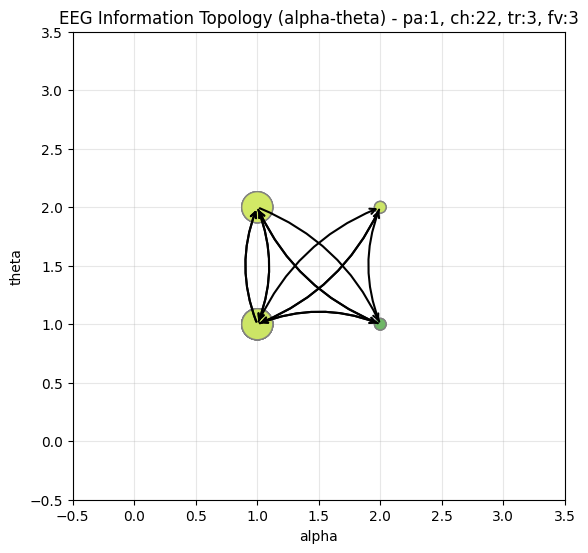

[1.31066231 1.95174393 2.40076262 2.7466523 ]
1.896767523256869
[0.40313577 0.25850356 0.18936444 0.14899623]
['0', '3', '2', '1']


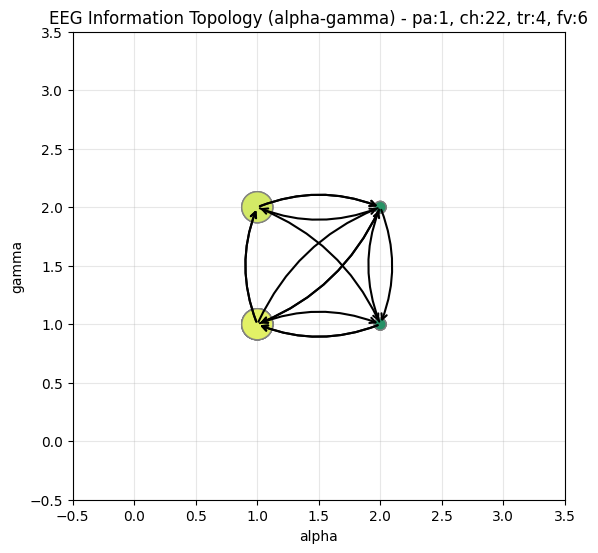

[1.30253621 1.95293514 2.40775322 2.75781508]
1.8939648447272752
[0.40541287 0.25829021 0.1884491  0.14784782]
['0', '3', '2', '1']


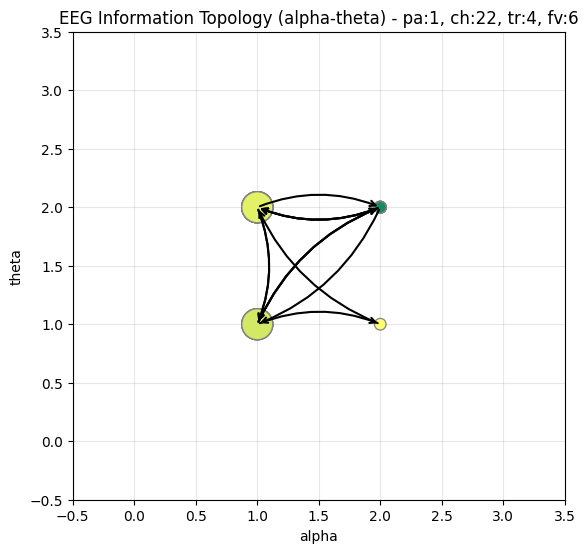

[1.3017543  1.95305129 2.40842964 2.75889524]
1.8936924802898882
[0.40563265 0.25826941 0.18836076 0.14773717]
['3', '0', '1', '2']


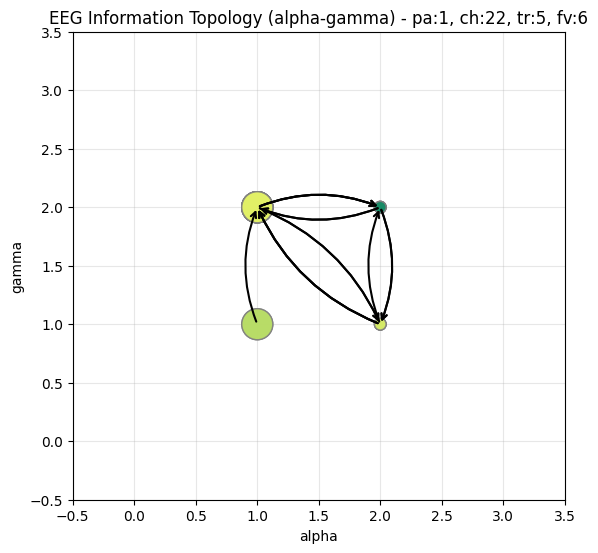

[1.29992323 1.9533244  2.4100163  2.76142888]
1.8930528130749298
[0.40614781 0.25822053 0.18815372 0.14747794]
['3', '0', '1', '2']


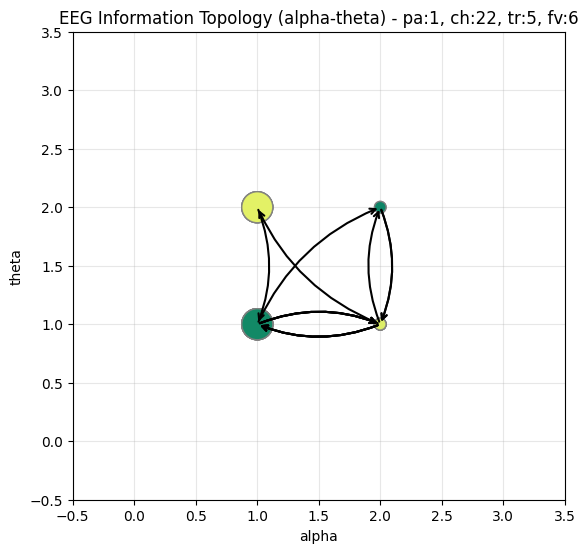

[1.30924602 1.95194951 2.40197587 2.74858954]
1.8962827045692343
[0.40353172 0.25846673 0.18920526 0.14879629]
['3', '0', '2', '1']


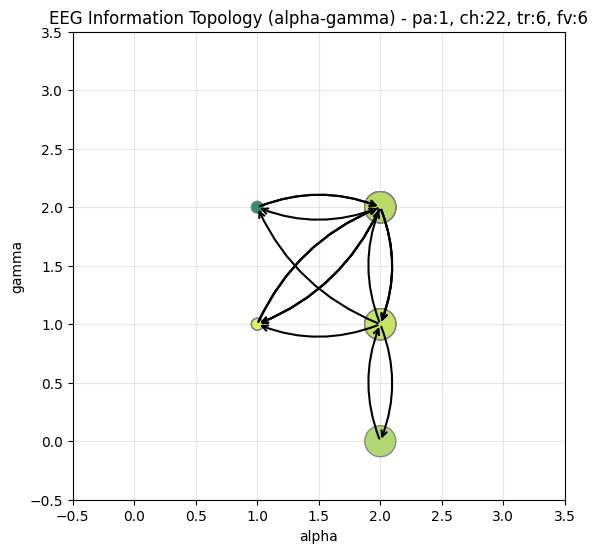

[1.30553424 1.95249232 2.4051658  2.7536833 ]
1.8950047818376115
[0.40457127 0.2583695  0.18878738 0.14827186]
['0', '3', '1', '2']


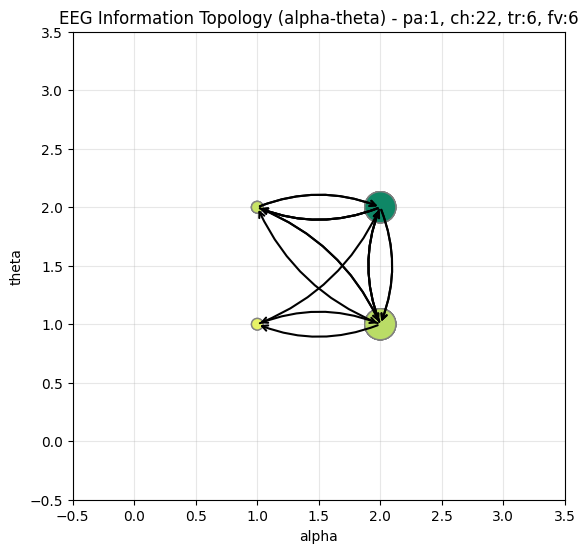

[1.31176974 1.95158376 2.39981545 2.74513999]
1.8971455397298587
[0.40282643 0.25853226 0.18948881 0.14915249]
['0', '3', '1', '2']


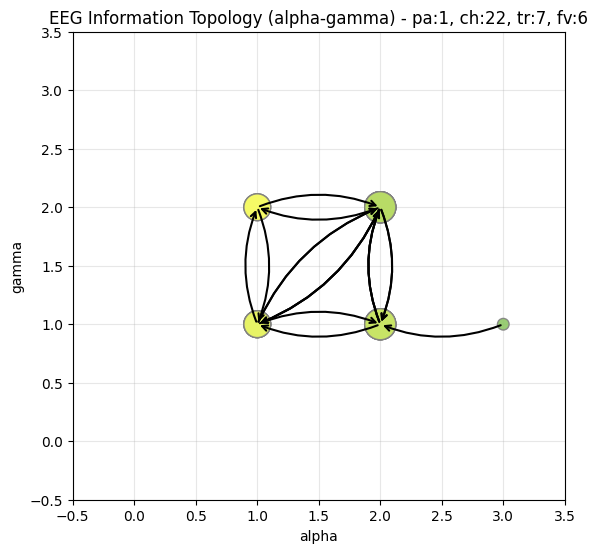

[1.30137793 1.9531073  2.40875547 2.75941554]
1.8935612125085066
[0.40573849 0.25825939 0.18831822 0.1476839 ]
['0', '3', '2', '1']


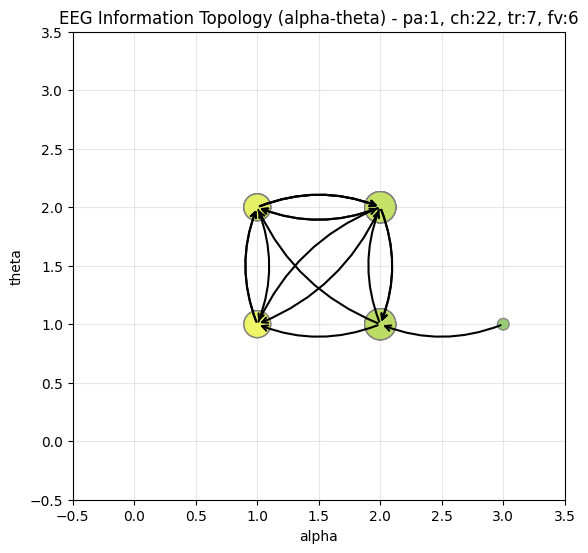

[1.31282401 1.95143173 2.39891498 2.7437023 ]
1.8975045352138555
[0.40253217 0.25855951 0.18960712 0.1493012 ]
['3', '0', '1', '2']


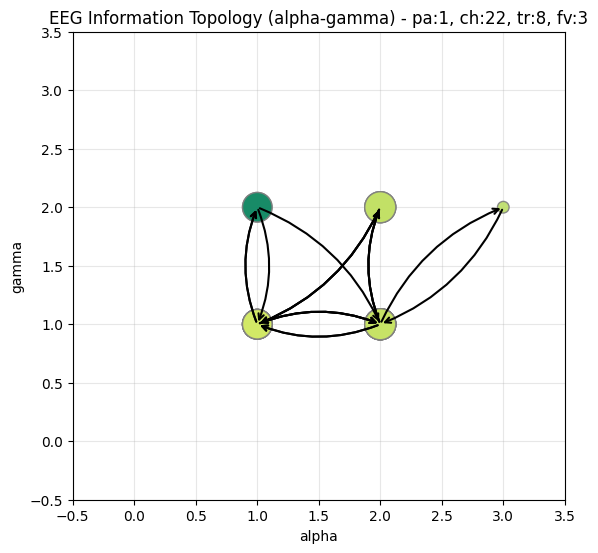

[1.30692728 1.95228791 2.40396686 2.75176877]
1.895485633480179
[0.40418081 0.25840611 0.18894433 0.14846875]
['0', '3', '2', '1']


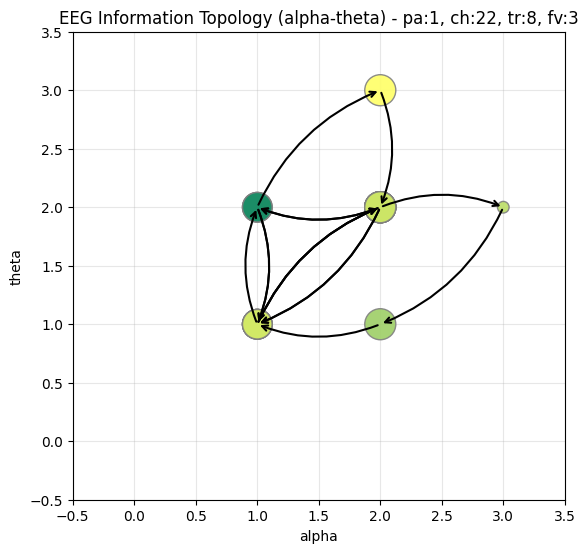

[1.31748798 1.95076439 2.3949456  2.73736584]
1.8990824680844773
[0.40123296 0.25867914 0.19012951 0.14995839]
['2', '1', '0', '3']


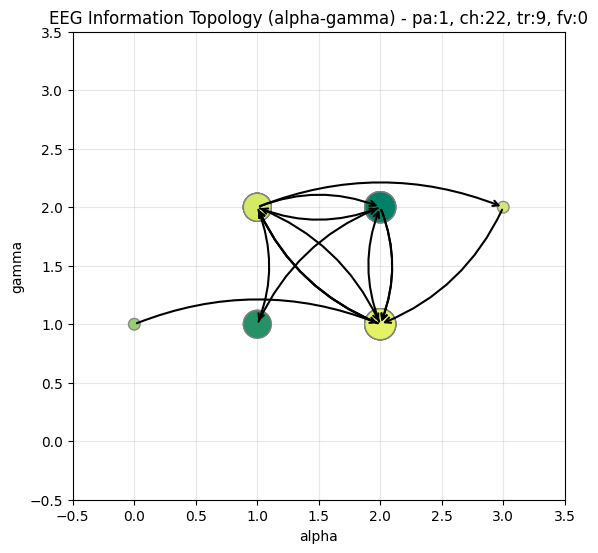

[1.30396027 1.9527243  2.40652298 2.75585055]
1.8944596780256746
[0.40501289 0.25832796 0.18860986 0.14804929]
['0', '3', '2', '1']


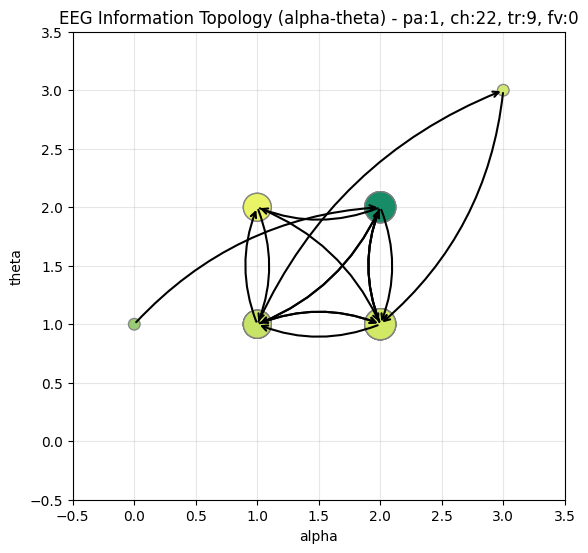

[1.31466931 1.9511667  2.39734172 2.74119062]
1.8981308399089416
[0.40201763 0.25860701 0.189814   0.14956136]
['0', '3', '2', '1']


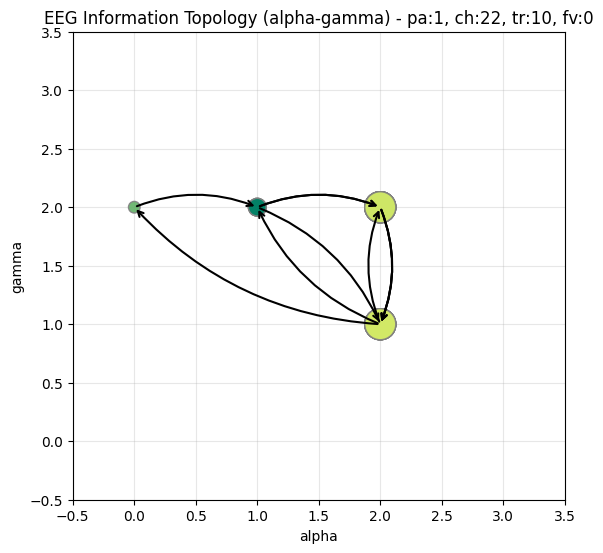

[1.30248333 1.95294298 2.40779894 2.7578881 ]
1.8939464401135977
[0.40542773 0.2582888  0.18844312 0.14784034]
['3', '0', '1', '2']


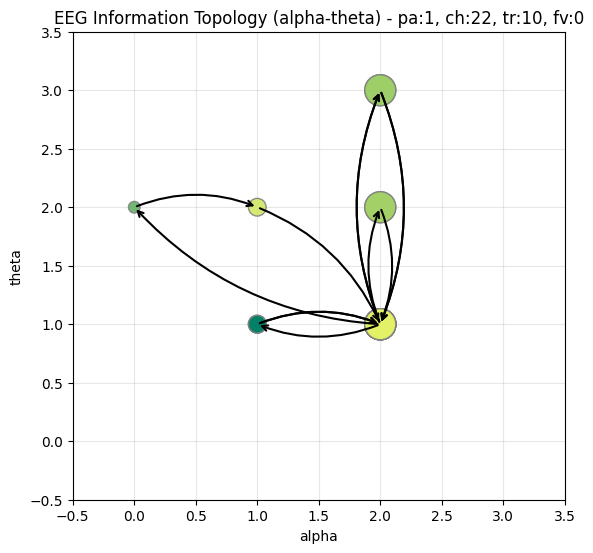

[1.30772915 1.95217063 2.40327768 2.75066827]
1.8957617444860204
[0.40395622 0.25842712 0.18903461 0.14858205]
['0', '3', '2', '1']


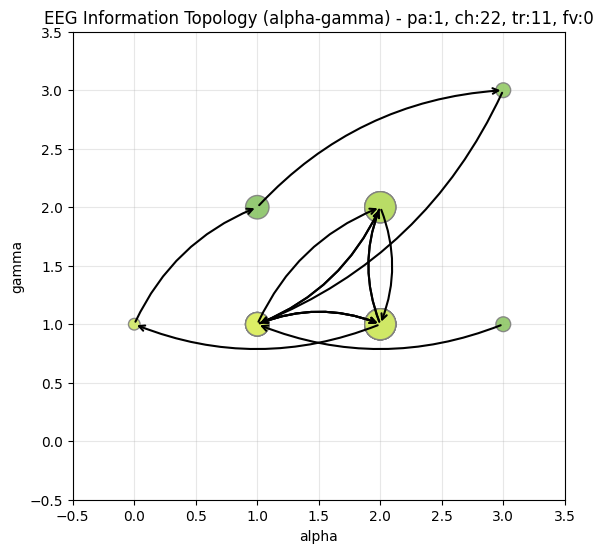

[1.30488839 1.95258737 2.40572237 2.75457207]
1.894781339266442
[0.40475242 0.25835248 0.18871456 0.14818054]
['0', '3', '2', '1']


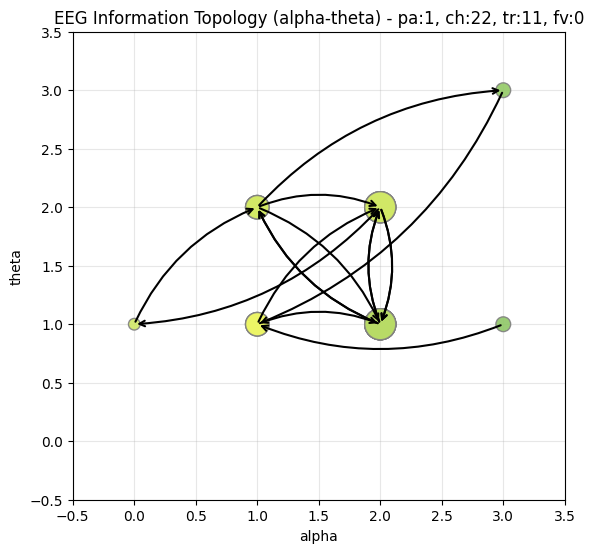

[1.31424507 1.95122752 2.39770309 2.74176752]
1.897987082947107
[0.40213587 0.25859611 0.18976646 0.14950156]
['0', '3', '2', '1']


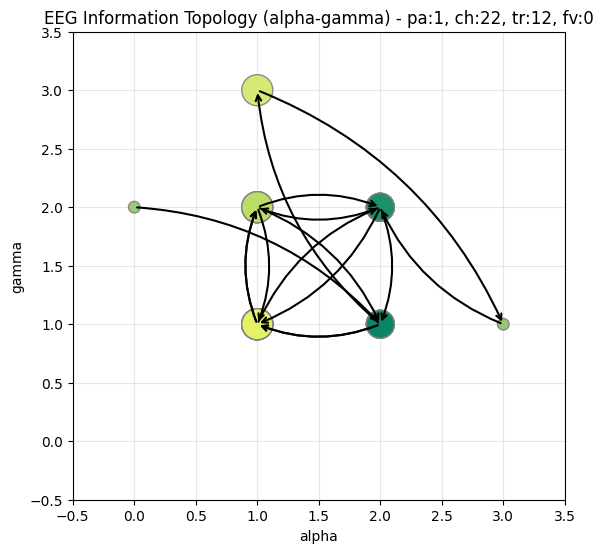

[1.30210421 1.95299928 2.40812685 2.75841172]
1.8938144261504786
[0.40553428 0.25827873 0.1884003  0.14778669]
['0', '3', '2', '1']


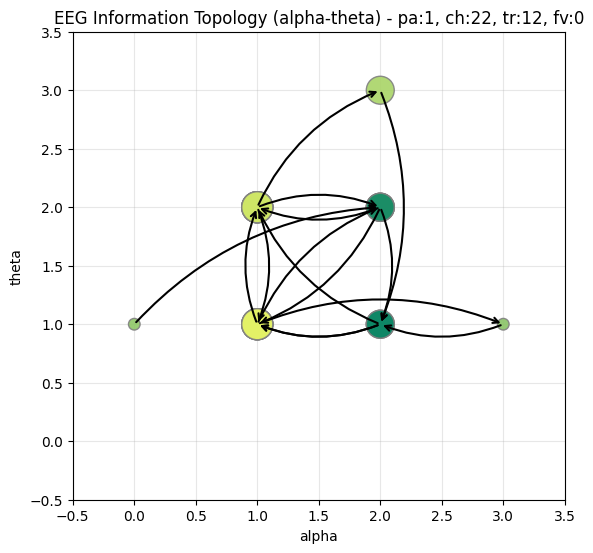

[1.30732183 1.95223017 2.40362767 2.75122714]
1.8956215532783955
[0.40407029 0.25841645 0.18898876 0.1485245 ]
['0', '3', '1', '2']


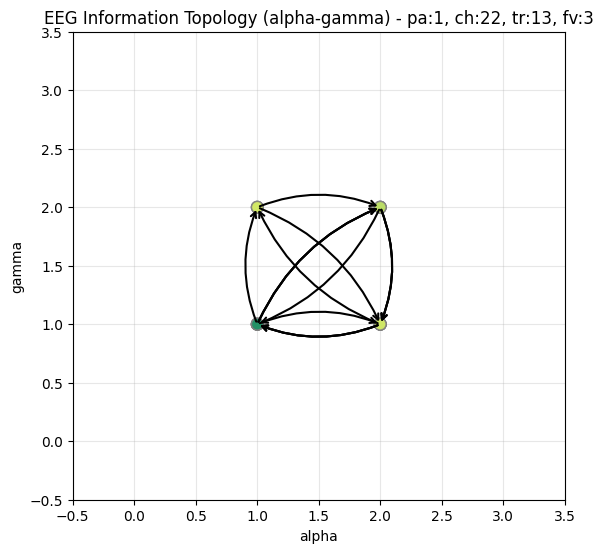

[1.30168231 1.953062   2.40849195 2.75899474]
1.8936673816601886
[0.4056529  0.2582675  0.18835263 0.14772698]
['3', '0', '2', '1']


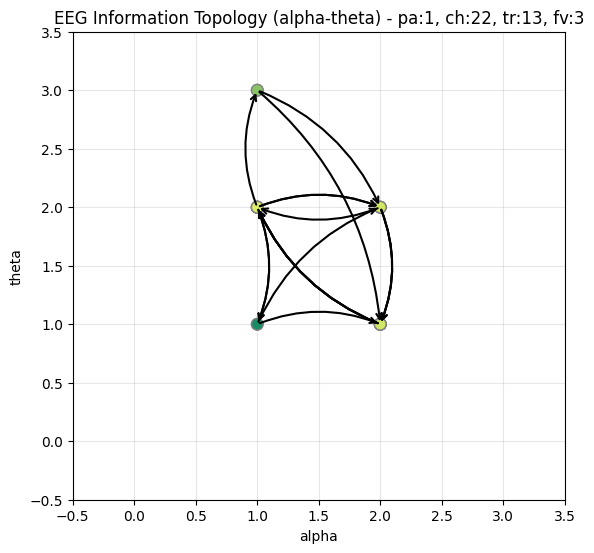

[1.31149603 1.9516233  2.40004943 2.74551356]
1.8970521997925767
[0.40290286 0.25852518 0.18945808 0.14911388]
['3', '0', '1', '2']


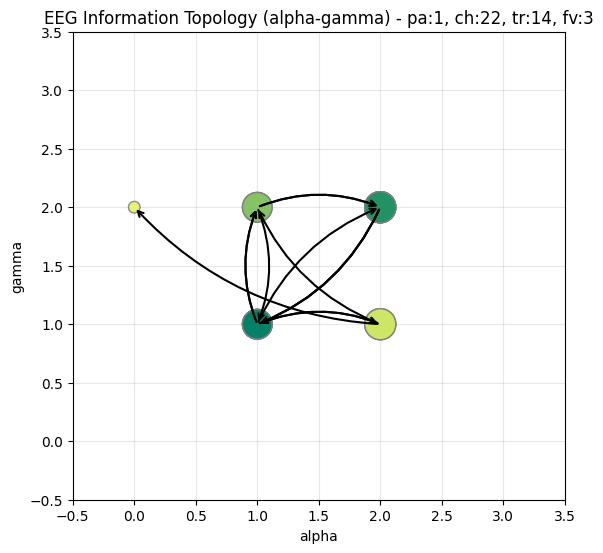

[1.3043573  1.95266568 2.40618038 2.75530346]
1.8945973587813307
[0.40490145 0.25833846 0.18865466 0.14810544]
['3', '0', '1', '2']


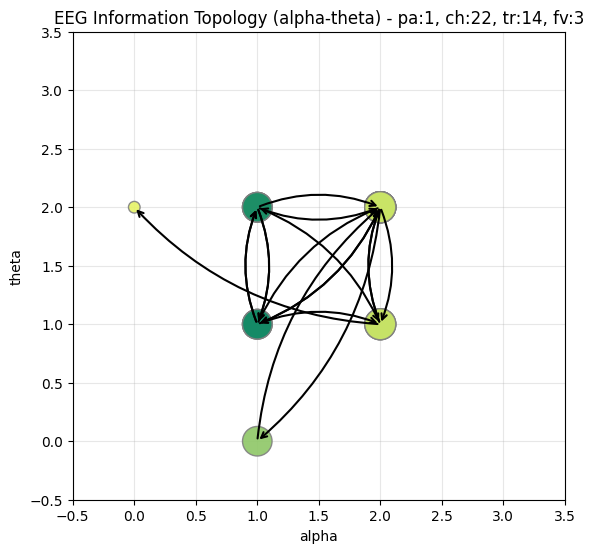

[1.31823425 1.95065837 2.39431262 2.73635558]
1.8993334027238957
[0.40102546 0.25869815 0.19021295 0.15006344]
['1', '3', '2', '0']


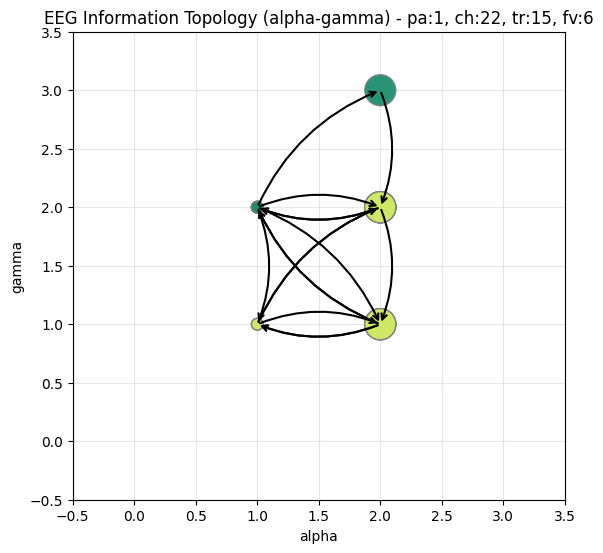

[1.30601349 1.9524219  2.40475309 2.75302426]
1.8951703790495797
[0.40443689 0.25838211 0.18884139 0.14833961]
['3', '0', '1', '2']


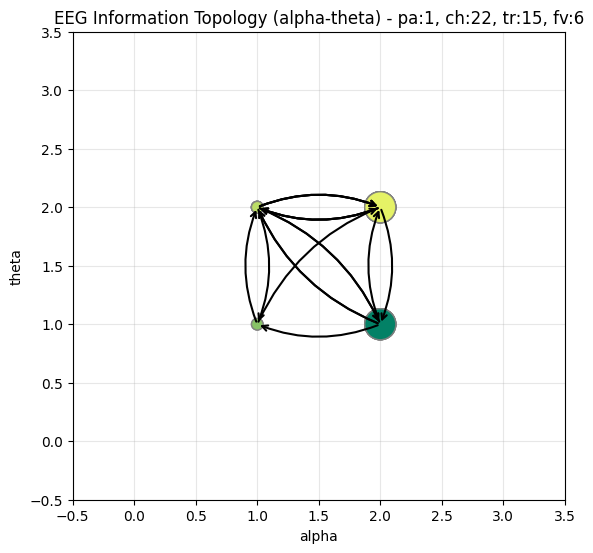

[1.31201964 1.95154768 2.3996019  2.74479903]
1.8972307121337153
[0.40275666 0.25853873 0.18951686 0.14918775]
['3', '0', '1', '2']


In [29]:
mat_files = [working_dir+'s01.mat', working_dir+'s02.mat', working_dir+'s03.mat', working_dir+'s04.mat', working_dir+'s05.mat', ]
eegfn.run_experiment_infotop(mat_files)

**Run Information Topology for one channel data read from a CSV file**

This shows how to run Information Topology for your own EEG signals.

(8063,)
[ 1.39008270e+00  1.83509881e+00 -1.11073832e+00 -2.59062203e+00
 -1.84425787e+00 -7.39794269e-01  2.39573835e+00  3.97638944e+00
  2.03843046e-03 -6.18212456e+00 -1.00808302e+01 -8.84823407e+00
 -4.26872670e+00 -2.18812278e-01  5.47654070e+00  1.14994103e+01
  1.11885411e+01  6.79755797e+00  2.05235775e+00 -4.16367511e+00
 -7.57429744e+00 -5.53163528e+00 -2.43023724e+00 -3.78047343e-01
 -5.79384006e-01 -2.33607458e+00 -8.06960332e-01  2.36697814e+00
  2.71206377e+00  2.27860794e+00]


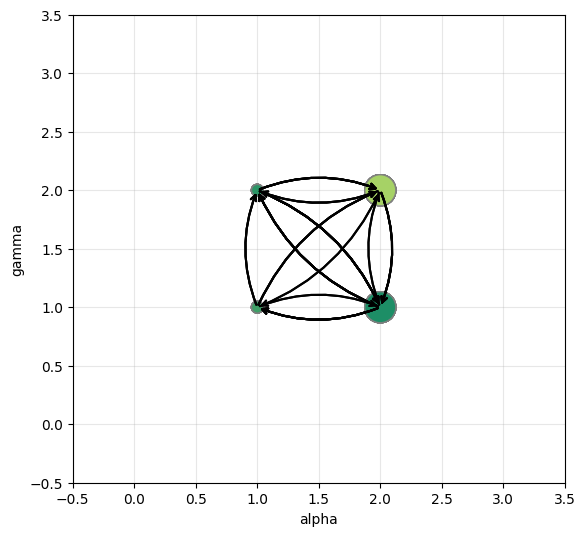

[1.30533221 1.95252203 2.40533985 2.75396124]
1.894934920574903
[0.40462792 0.25836418 0.1887646  0.1482433 ]
['3', '0', '2', '1']


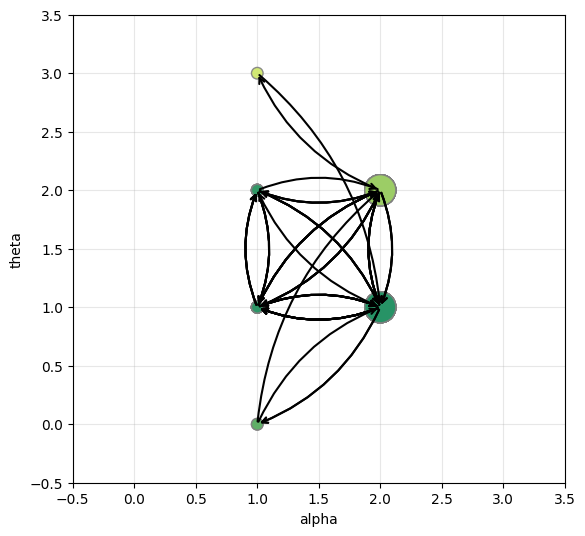

[1.31013108 1.95182095 2.40121744 2.74737851]
1.8965858564725202
[0.40328424 0.25848976 0.18930476 0.14892124]
['3', '0', '1', '2']


In [30]:
# Read the CSV file for the specified trial index
csv_file_name =  working_dir + f'trial_1_channel_2_data.csv'
channel_data = np.loadtxt(csv_file_name, delimiter=',', skiprows=1)
print(channel_data.shape)
print(channel_data[:30])

eegfn.run_infotop_customised_eeg(channel_data)

In [31]:
## Experiment 9: Symoblization of Video Data

In [32]:
video_path = working_dir + "events_001.mov"
video_info = videosym.get_video_info(video_path)

if video_info:
    print("Video Frame Count:", video_info["frame_count"])
    print("Video Frame Rate:", video_info["frame_rate"])
    print("Video Duration (seconds):", video_info["duration_seconds"])

Video Frame Count: 378
Video Frame Rate: 10.0
Video Duration (seconds): 37.8


In [33]:

all_patches, frame_engery = videosym.get_patches_and_engery(video_path, pieces_per_row = 5, pieces_per_col = 5 )

(288, 384, 3)
250
(205, 384, 3)
(288, 384, 3)
250
(205, 384, 3)
(288, 384, 3)
250
(205, 384, 3)
(288, 384, 3)
250
(205, 384, 3)
(288, 384, 3)
250
(205, 384, 3)
(288, 384, 3)
250
(205, 384, 3)
(288, 384, 3)
250
(205, 384, 3)
(288, 384, 3)
250
(205, 384, 3)
(288, 384, 3)
250
(205, 384, 3)
(288, 384, 3)
250
(205, 384, 3)
(288, 384, 3)
250
(205, 384, 3)
(288, 384, 3)
250
(205, 384, 3)
(288, 384, 3)
250
(205, 384, 3)
(288, 384, 3)
250
(205, 384, 3)
(288, 384, 3)
250
(205, 384, 3)
(288, 384, 3)
250
(205, 384, 3)
(288, 384, 3)
250
(205, 384, 3)
(288, 384, 3)
250
(205, 384, 3)
(288, 384, 3)
250
(205, 384, 3)
(288, 384, 3)
250
(205, 384, 3)
(288, 384, 3)
250
(205, 384, 3)
(288, 384, 3)
250
(205, 384, 3)
(288, 384, 3)
250
(205, 384, 3)
(288, 384, 3)
250
(205, 384, 3)
(288, 384, 3)
250
(205, 384, 3)
(288, 384, 3)
250
(205, 384, 3)
(288, 384, 3)
250
(205, 384, 3)
(288, 384, 3)
250
(205, 384, 3)
(288, 384, 3)
250
(205, 384, 3)
(288, 384, 3)
250
(205, 384, 3)
(288, 384, 3)
250
(205, 384, 3)
(288, 38

In [34]:
enger_diff_matrix = videosym.get_engery_diff_matrix(frame_engery)

In [35]:
import cv2

for i in range(len(enger_diff_matrix)):

    key = enger_diff_matrix[i][0]
    print(key)
    print('diff value', enger_diff_matrix[i][1])
    patch_data = all_patches[i][key]
    plt.imshow(cv2.cvtColor(patch_data, cv2.COLOR_BGR2RGB))
    plt.title(f'Piece at (key)')
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [36]:
frame_engery_patches = videosym.get_interest_patch(all_patches, enger_diff_matrix)

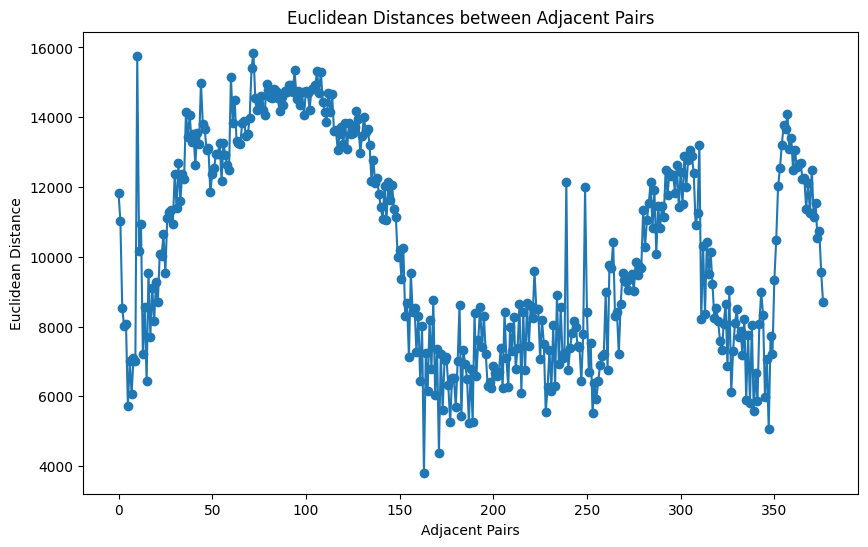

In [40]:
# Compute Euclidean distance between each adjacent pair
euclidean_distances = [videosym.compute_euclidean_distance(frame_engery_patches[i], frame_engery_patches[i+1]) for i in range(len(frame_engery_patches)-1)]
#print(euclidean_distances)
# Plot the Euclidean distances
plt.figure(figsize=(10, 6))
plt.plot(euclidean_distances, marker='o')
plt.xlabel('Adjacent Pairs')
plt.ylabel('Euclidean Distance')
plt.title('Euclidean Distances between Adjacent Pairs')
plt.show()

In [38]:
dist_norm = eegfn.min_max_norm(euclidean_distances)
symbols =  videosym.symbolise_video_energy_states(dist_norm, ngram=1)

['B', 'B', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D']
['A', 'C', 'B', 'D', 'D', 'D', 'C', 'D', 'C', 'D']
['C', 'D', 'C', 'C', 'B', 'C', 'B', 'B', 'B', 'B']
['A', 'B', 'A', 'B', 'A', 'A', 'A', 'A', 'A', 'A']
['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B']
['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A']
['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A']
['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A']
['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A']
['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A']
['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A']
['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A']
['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A']
['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B']
['B', 'B', 'A', 'B', 'A', 'B', 'A', 'B', 'B', 'C']
['C', 'C', 'C', 'D', 'D', 'D', 'C', 'D', 'D', 'D']
['D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'C', 'D']
['D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D']
['D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D']
['D', 'D', 'D', 'D', 'D', 'D', 

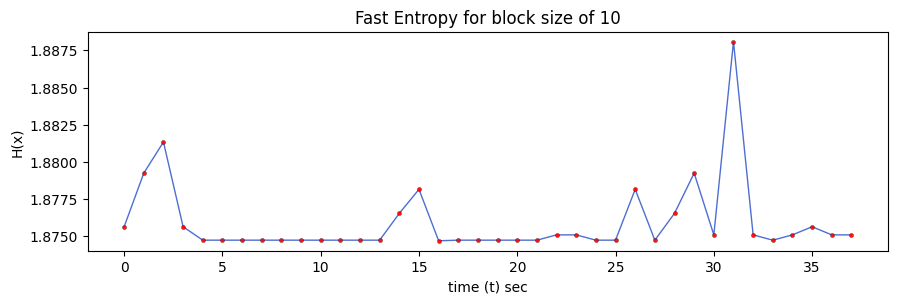

In [39]:
block_size = 10
block_entropy = []
for i in range(0, len(symbols), block_size):
    # get the current block
    current_chunk = symbols[i:i+block_size]
    print(current_chunk)
    # set up params for calculating fast entropy
    selected_symbol = symfn.most_frequent_symbol(current_chunk)
    Naw = len(current_chunk)
    M=4

    entropy, p = slaitai_entropy.FastEntropy4_czml(current_chunk, Naw, selected_symbol, M, 0.0075, 4.2026, 4.5362, zml_model='zml', eta=0.2)
    block_entropy.append(entropy)



print(block_entropy)
fig = plt.figure(figsize=(10, 3))
ax = fig.add_axes([0.15, 0.17, 0.8, 0.73])
ax.plot(block_entropy,
             marker='o',  # each marker will be rendered as a circle
             markersize=3,  # marker size
             markerfacecolor='red',  # marker facecolor
             markeredgecolor='black',  # marker edgecolor
             markeredgewidth=0.2,  # marker edge width
             linestyle='solid',  # line style will be dash line
             linewidth=PlotLineWidth,  # line width
             alpha=0.9,
             color=royalblue3)

ax.set_xlabel("time (t) sec")
ylabelstr = "H(x)"
ax.set_ylabel(ylabelstr)
ax.set_title("Fast Entropy for block size of " + str(block_size))
plt.show()